In [ ]:
# hide
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from functools import wraps
from pathlib import Path
from datetime import datetime

from sklego.meta import DecayEstimator
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from common import start_pipeline, rename_columns, remove_rows_columns, set_dtypes, trim_dataset, add_station_name_to_cols, handle_missing_values

In [2]:
log_interval = 5  # minutes
samples_per_week = int(60 / log_interval * 24 * 7)
start_time = "2013-05-22"
end_time = "2020-05-22"
train_end_time = "2017-02-01"
intervention_time = "2018-02-01"
outcome_pollutant = ['NOX']
predictor_pollutants = ['NOX']#, 'NO', 'NO2', 'PM2.5', 'CO']
stations = list(Path().glob("Data/*.csv"))
num_controls = len(stations) - 1

In [3]:
def prep_data_station(file_path):
    df = pd.read_csv(file_path, engine='python')
    df = (df.
     pipe(start_pipeline).
     pipe(rename_columns).
     pipe(remove_rows_columns).
     pipe(set_dtypes).
     pipe(trim_dataset, start_time, end_time).
     pipe(add_station_name_to_cols, station_name=file_path.parts[-1][:-4]).
     pipe(handle_missing_values))
    
    df = df.groupby(pd.Grouper(freq='D')).mean()
#     df_roll = df.rolling(28*3).mean()

#     df_roll=df.rolling(window=samples_per_week*4, center=False, min_periods=samples_per_week
#               ).mean()[samples_per_week*4::samples_per_week*2]
#     y = df_roll[outcome_pollutant]
    
    # X is average annual pollution
#     x = df_roll.groupby(pd.Grouper(freq='Y')).mean().loc[:intervention_time, predictor_pollutants].values.reshape(-1,1)
#     assert(x.shape[0] == len(predictor_pollutants)*5)  # 5 years (2013-2017 inclusive) * 5 predictors
    
    # X is just like Y until the intervention
#     x = df_roll.loc[:intervention_time, predictor_pollutants].values.reshape(-1,1)
    
    # X is exp weighted MA
#     x = df_roll.ewm(span=samples_per_week*8).mean().loc[:intervention_time, predictor_pollutants].fillna(0).values.reshape(-1,1)
    
    return df

In [4]:
def prep_data():
    df_all = None
    for station in stations:
        df_station = prep_data_station(station)
        if df_all is None:
            df_all = df_station
        else:
            assert pd.Index.equals(df_all.index, df_station.index)
            df_all = df_all.merge(right=df_station, how='inner', left_index=True, right_index=True)
        print(f'Finished extracting data from {station.parts[-1][:-4]}')
    return df_all

df_all = prep_data()
df_all

Finished extracting data from TelAviv
Finished extracting data from Raanana
Finished extracting data from Jerusalem
Finished extracting data from Haifa
Finished extracting data from Rashlatz


,TelAviv_Benzene,TelAviv_PM2.5,TelAviv_CO,TelAviv_NO2,TelAviv_NO,TelAviv_NOX,Raanana_PM2.5,Raanana_CO,Raanana_NO2,Raanana_NOX,...,Haifa_CO,Haifa_NO2,Haifa_NOX,Haifa_NO,Rashlatz_BR,Rashlatz_PM2.5,Rashlatz_CO,Rashlatz_NO2,Rashlatz_NOX,Rashlatz_NO
DateTime,,,,,,,,,,,,,,,,,,,,,
2013-05-22,0.000000,0.000000,0.366319,25.141319,14.364236,38.983333,20.978125,0.450694,18.716667,26.971528,...,0.344792,25.597569,52.212153,27.023264,0.0,27.222222,0.373264,26.313889,48.598958,22.282639
2013-05-23,0.000000,0.000000,0.353819,23.927778,11.566667,35.035417,22.552083,0.456250,16.278819,24.330208,...,0.343403,19.360069,42.068750,23.607986,0.0,35.963194,0.450694,32.136806,61.660069,29.533333
2013-05-24,0.000000,0.000000,0.321875,16.835069,5.102083,20.432986,23.318056,0.468403,17.924306,22.590625,...,0.317708,19.113194,37.083333,18.978472,0.0,11.650000,0.374653,19.509722,29.645486,10.167361
2013-05-25,0.000000,0.000000,0.220139,7.006597,0.236806,4.828472,13.181250,0.326389,4.932292,3.620833,...,0.198611,4.523611,2.668056,0.012847,0.0,6.996181,0.268403,8.748264,12.928819,4.253125
2013-05-26,0.000000,0.000000,0.216319,15.040972,9.672222,24.200347,10.250694,0.334722,10.384028,14.407986,...,0.183333,9.250000,12.223611,3.914931,0.0,15.486458,0.300000,21.161458,44.554167,23.397917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-18,0.235660,14.543750,0.605556,26.144444,16.046528,42.178819,24.245833,0.243750,14.953472,17.135764,...,0.589583,32.100694,67.187847,35.260417,0.0,26.478472,0.703125,24.156944,35.703125,11.381597
2020-05-19,0.307396,35.351389,0.648611,26.620833,19.970486,46.590972,30.991319,0.198264,12.563542,15.476736,...,0.560417,36.371528,73.590972,37.323611,0.0,34.398264,0.711806,23.965278,47.090278,23.083681
2020-05-20,0.376562,33.971528,0.686458,33.000000,17.451389,50.453472,34.297222,0.215972,14.851042,17.296181,...,0.530903,34.629167,60.614583,26.130903,0.0,36.876736,0.763542,26.260764,40.678819,14.234722


In [5]:
df_all.columns #"Haifa_NOX"
df = df_all.copy()

In [6]:
def plot_outcome(df_haifa, synthetic_outcome):
    df_haifa = df_haifa.rename(columns={outcome_pollutant[0]:f'Real {outcome_pollutant[0]} Haifa'})
    df_haifa[f'Synthetic {outcome_pollutant[0]} Haifa'] = synthetic_outcome
    ax=df_haifa.plot(figsize=(20, 8));
    ax.grid()
    ax.set_ylabel(f'{outcome_pollutant[0]} [{units[outcome_pollutant[0]]}]')
    ax.axvline(intervention_time, color='m', ls='--', lw=3)
#     ax.text(s='LEZ implementation', x=intervention_time, y=100, size=12, color='m');
    sns.despine

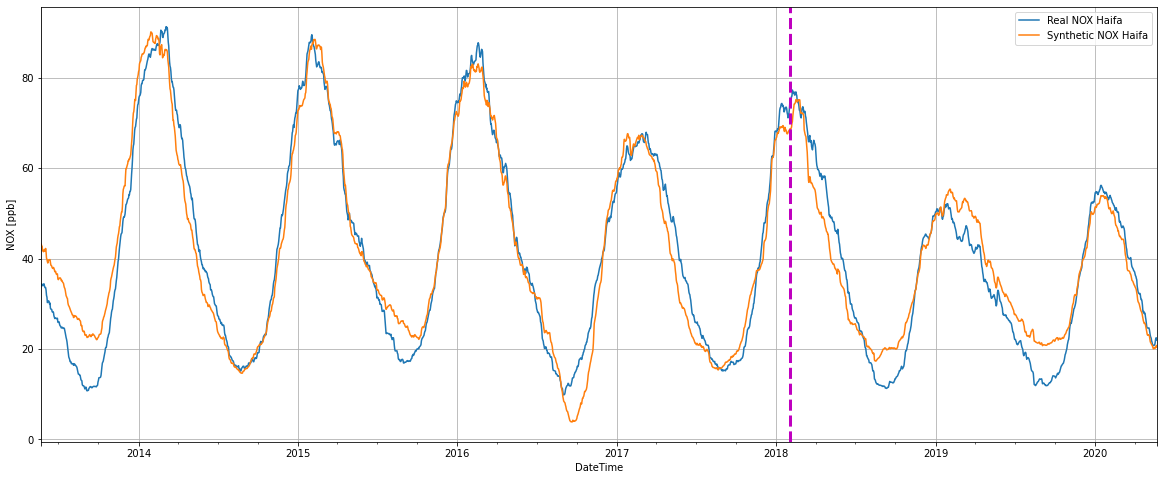

In [7]:
# The most simple linear regression of X - unweighted predictors, raw data
W = np.linalg.lstsq(X[:,1:], X[:,0,None], rcond=None)[0]
synthetic_outcome = Y[:,1:].dot(W)
plot_outcome(df_haifa, synthetic_outcome)

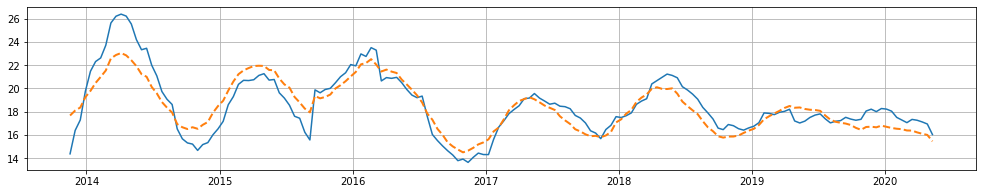

In [58]:
model = Lasso(alpha=1.0)
decay = 0.98
window = 180
step = 14
outcome = "PM2.5"  # "NOX"

df = df_all.copy()

df = df.rolling(window).mean().iloc[window-1::step]

est = DecayEstimator(model=Lasso(), decay=0.98)
fig = plt.figure(figsize=(17,3))
ax = fig.add_subplot(111)
colname = "Haifa_" + outcome
ax.plot(df.index,df[colname]);

df_predictors = df[[col for col in df.columns if not col.startswith('Haifa')]]
X_train = df_predictors[:intervention_time]
y_train = df.loc[:intervention_time, colname]
X_test = df_predictors
synthetic_control = est.fit(X_train, y_train).predict(X_test)
ax.plot(df.index, synthetic_control, '--', linewidth=2.0);
ax.grid()

In [122]:
coefs = pd.DataFrame(data=est.estimator_.coef_, index=list(df_predictors), columns=['coef_value'])
coefs['abs_coef_value'] = coefs['coef_value'].abs()
coefs = coefs.sort_values(by='abs_coef_value', ascending=False)
coefs[coefs['abs_coef_value'] > 0]

,coef_value,abs_coef_value
Raanana_PM2.5,0.121512,0.121512
Rashlatz_NOX,0.115595,0.115595
TelAviv_PM2.5,0.102227,0.102227
Jerusalem_PM2.5,0.080918,0.080918
Jerusalem_NOX,-0.011094,0.011094


In [181]:
def plot_pipe(df, real, synthetic, outcome):
    fig = plt.figure(figsize=(17,3))
    ax = fig.add_subplot(111)

    ax.plot(df.index,real, label='Real Haifa ' + outcome,  linewidth=3.0);
    ax.plot(df.index, synthetic, '--', linewidth=3.0, label='Synthetic Haifa ' + outcome);
    ax.grid()
    ax.legend()
    lez_time = datetime.strptime(intervention_time, '%Y-%m-%d')
    ax.axvline(lez_time, color='m', ls='--', lw=3)
    ax.text(s=' LEZ implementation', x=lez_time, y=24.3, size=12, color='m');
    fig.savefig("name", dpi=300)
    
def calc_synthetic_control(model, X_pre, Y_pre, X_all):
    return model.fit(X_pre, Y_pre).predict(X_all)

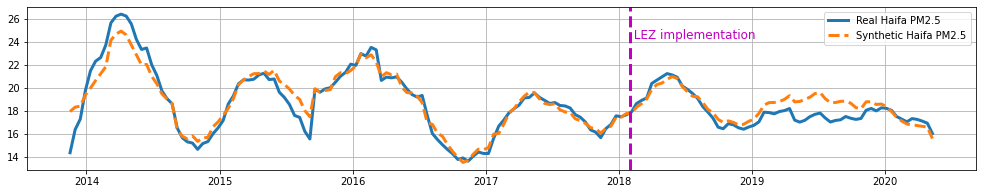

In [184]:
# pipe with decay
model = Ridge(alpha=0.8)
# model = LinearRegression()
decay = 0.95
model = DecayEstimator(model=model, decay=decay)
window = 180
step = 14
outcome = "PM2.5"  # "NOX"

df = df_all.copy()

df = df.rolling(window).mean().iloc[window-1::step]

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("meta_model", model)
])

df_predictors = df[[col for col in df.columns if not col.startswith('Haifa')]]
X_train = df_predictors[:intervention_time]
y_train = df.loc[:intervention_time, "Haifa_" + outcome]
X_test = df_predictors
synthetic = pipe.fit(X_train, y_train).predict(X_test)
real = df["Haifa_" + outcome]

plot_pipe(df, real, synthetic, outcome)


In [107]:
mod = GridSearchCV(estimator=pipe,
                   param_grid={
                     'meta_model__model__alpha': [0.1, 1, 10]
                   },
                   cv=TimeSeriesSplit(n_splits=2))
mod.fit(X_train, y_train);
pd.DataFrame(mod.cv_results_)

/home/tom/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/tom/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/tom/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/tom/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarni

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_meta_model__model__alpha,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007418,0.001194,0.002596,0.000779,0.1,{'meta_model__model__alpha': 0.1},0.656988,0.442172,0.549580,0.107408,2
1,0.005919,0.000701,0.001365,0.000024,1,{'meta_model__model__alpha': 1},0.703583,0.443259,0.573421,0.130162,1
2,0.004690,0.000558,0.001616,0.000224,10,{'meta_model__model__alpha': 10},-0.000859,-2.447521,-1.224190,1.223331,3


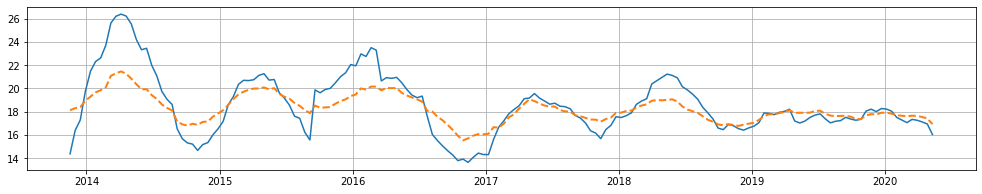

In [108]:
synthetic = calc_synthetic_control(model=mod.best_estimator_, X_pre=X_train, Y_pre=y_train, X_all=X_test)
plot_pipe(df, real, synthetic)

#### Trying to validate the EPA report (unsuccessfully)

In [143]:
y_all["2018-02":"2019-01"].mean().item()

37.046074452326444